In [1]:
import pathlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [2]:
work_path = pathlib.Path.cwd()
data_path = Path(work_path, 'data', 'Telco-Customer-Churn.csv')
data = pd.read_csv(data_path)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Легенда — описание переменных, которые будут использоваться в анализе

+ **Customer ID** —      ID Клиента
+ **gender** —           Пол (мужчина или женщина) 
+ **SeniorCitizen** —    Является ли клиент пожилым гражданином ( 1(Да), 0(Нет) ) 
+ **Partner** —          Есть ли у клиента партнер (Да, Нет) 
+ **Dependents** —       Есть ли у клиента иждивенцы (Да, Нет) 
+ **tenure** —           Количество месяцев, в течение которых клиент оставался в компании 
+ **PhoneService** —     Есть ли у клиента телефонная служба (Да, Нет) 
+ **MultipleLines** —    Есть ли у клиента несколько линий (Да, Нет, Нет телефонной службы) 
+ **InternetService** —  Интернет-провайдер клиента (DSL, оптоволокно, нет) 
+ **OnlineSecurity** —   Есть ли у клиента онлайн-безопасность (да, нет, нет интернет-сервиса) 
+ **OnlineBackup**  —    Есть ли у клиента онлайн-резервное копирование (да, нет, нет интернет-сервиса) 
+ **DeviceProtection** — Есть ли у клиента защита устройства (да, нет, нет интернет-сервиса) 
+ **TechSupport** —      Есть ли у клиента техническая поддержка (да, нет, нет интернет-сервиса) 
+ **StreamingTV** —      Есть ли у клиента потоковое телевидение (да, нет, нет интернет-сервиса) 
+ **StreamingMovies** —  Есть ли у клиента потоковое воспроизведение фильмов (да, нет, нет интернет-сервиса)
+ **Contract** —         Срок контракта заказчика (Месяц в месяц, Один год, Два года) 
+ **PaperlessBilling** — Есть ли у клиента безбумажный счет (Да, Нет) 
+ **PaymentMethod** — Способ оплаты клиента (электронный чек, чек по почте, банковский перевод (автоматический), кредитная карта (автоматический)
+ **MonthlyCharges** —   Сумма, списываемая с клиента ежемесячно 
+ **TotalCharges** —     Общая сумма, списанная с клиента 
+ **Churn** —            Ушел ли клиент (да, нет)

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


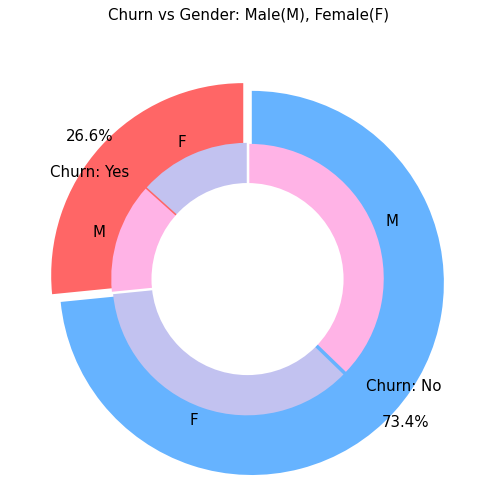

In [5]:
plt.figure(figsize=(7, 7))
labels =["Churn: Yes","Churn: No"]
values = [1869,5163]
labels_gender = ["F", "M", "F", "M"]
sizes_gender = [939, 930, 2544, 2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0', '#ffb3e6', '#c2c2f0', '#ffb3e6']
explode = (0.3, 0.3) 
explode_gender = (0.1, 0.1, 0.1, 0.1)
textprops = {"fontsize": 15}

# График
plt.pie(values, labels=labels, autopct='%1.1f%%', pctdistance=1.08, labeldistance=0.8,
        colors=colors, startangle=90, frame=True, explode=explode, radius=10, textprops=textprops, 
        counterclock = True)
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, startangle=90, 
        explode=explode_gender, radius=7, textprops=textprops, counterclock = True)

# Рисуем круг
centre_circle = plt.Circle((0,0), 5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Churn vs Gender: Male(M), Female(F)', fontsize=15, y=1.1)
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Наблюдается дисбаланс классав

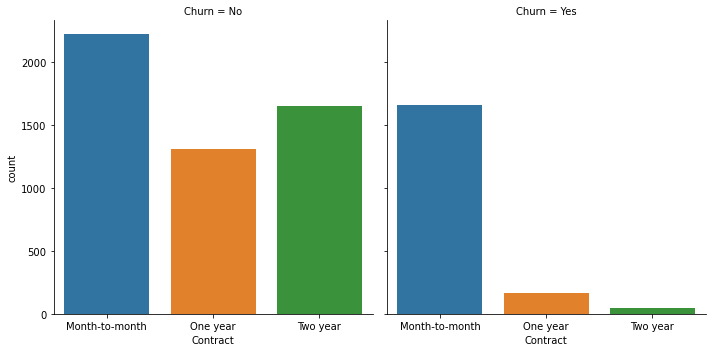

In [6]:
sns.catplot(data=data, x='Contract', col='Churn', kind='count',  height=5, aspect=1);

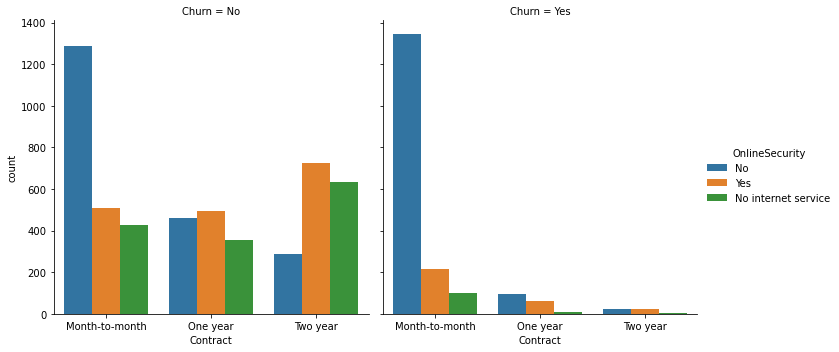

In [7]:
sns.catplot(data=data, x='Contract',  hue='OnlineSecurity', col='Churn', kind='count',  height=5, aspect=1);

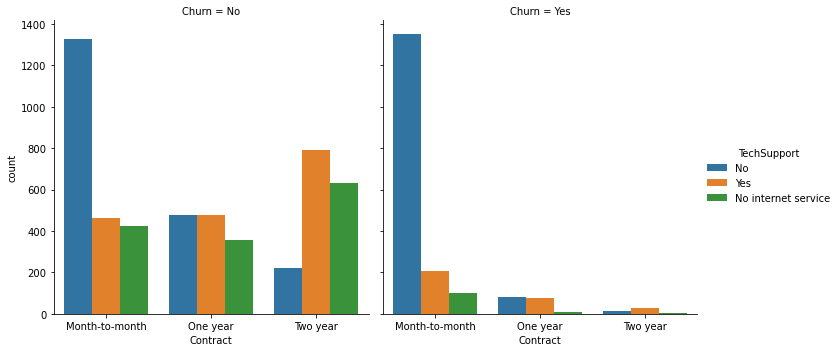

In [8]:
sns.catplot(data=data, x='Contract', hue='TechSupport', col='Churn', kind='count',  height=5, aspect=1);

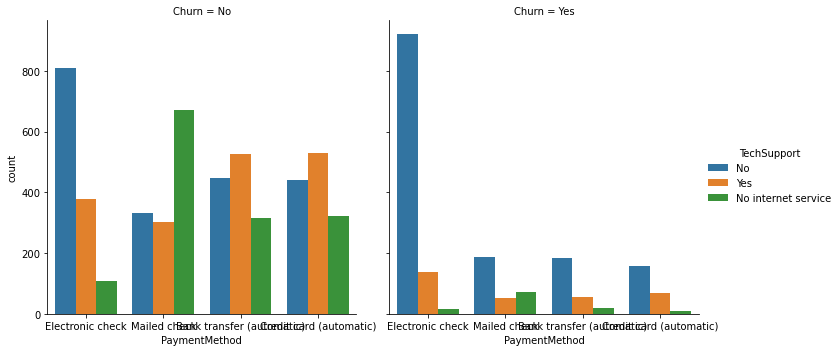

In [9]:
sns.catplot(data=data, x='PaymentMethod', hue='TechSupport', col='Churn', kind='count',  height=5, aspect=1);

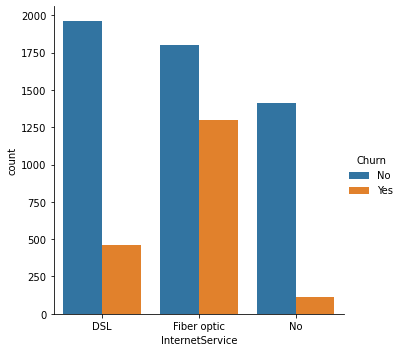

In [10]:
sns.catplot(data=data, x='InternetService', hue='Churn', kind='count',  height=5, aspect=1);

In [11]:
two_categorical_column = []
other_categorical_column = []
for column in data.columns:
    if (data[column].nunique() == 2) and (data[column].dtype != 'int64'):
        two_categorical_column.append(column)
    elif data[column].nunique() in (3, 4):
        other_categorical_column.append(column)        
print(f'Признаки с двумя катерогиями-{two_categorical_column}\n\
Признаки с множественными категориями-{other_categorical_column}')

Признаки с двумя катерогиями-['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
Признаки с множественными категориями-['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [12]:
# Кодировка бинарных признаков
for column in two_categorical_column:
    if any(data[column] == 'Yes'):
        data[column] = np.where(data[column] == 'Yes', 1, 0)
    else:
        data[column] = np.where(data[column] == 'Male', 1, 0)

In [13]:
# Кодирование с помощью OneHotEncoder
ohe = OneHotEncoder()
# Преобразуем в целочисленные признаки
data_ohe = ohe.fit_transform(data[other_categorical_column]).toarray()
# Создаем DataFrame
df_data_ohe = pd.DataFrame(data_ohe, columns=ohe.get_feature_names_out())
# Удаляем столбц
data.drop(other_categorical_column + ['customerID'], axis=1, inplace=True)
# Соединяем два DataFrame
data = pd.concat([data, df_data_ohe], axis=1)

data.loc[data.TotalCharges == ' ', 'TotalCharges'] = np.nan
data.dropna(axis=0, inplace=True)
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [14]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
data.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.592719,64.798208,2283.300441,0.265785,...,0.395478,0.216155,0.388367,0.551052,0.209329,0.239619,0.219283,0.216297,0.336320,0.228100
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.491363,30.085974,2266.771362,0.441782,...,0.488988,0.411650,0.487414,0.497422,0.406858,0.426881,0.413790,0.411748,0.472483,0.419637
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.587500,401.450000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1397.475000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.862500,3794.737500,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


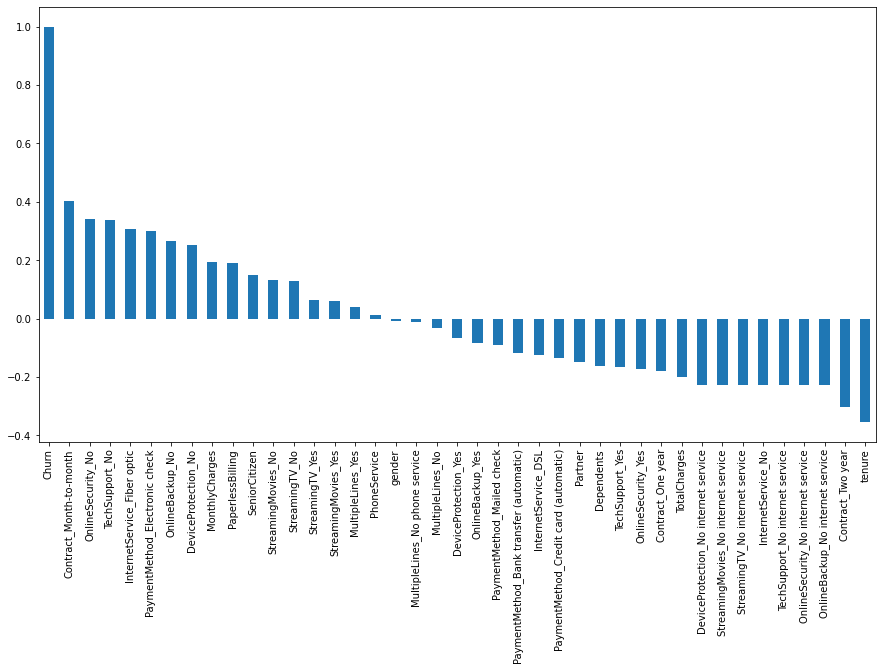

In [16]:
plt.figure(figsize=(15,8))
data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar');

In [17]:
# Признаки
X = data.drop('Churn', axis=1)
# Таргет
y = data['Churn']
# Разделение данных на обучающий и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, stratify=y.values, random_state=42)

# **Обучение модели**

## Случайный лес

In [18]:
# Количество деревьев
n_estimators = [int(x) for x in np.linspace(100, 1200, 10)]
# Число признаков для выбора расщепления
max_features = ['auto', 'sqrt']
# Максимальная глубина деревьев
max_depth = [int(x) for x in np.linspace(3, 20, 6)]
# Минимальное число объектов, при котором выполняется расщепление
min_samples_split = [2, 5, 10, 15, 100]
# Ограничение на число объектов в листьях
min_samples_leaf = [1, 2, 5, 10]
# Использование для построения деревьев подвыборки с возвращением
bootstrap = [True, False]
# Сетка гиперпараметров 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }

print(random_grid)

{'n_estimators': [100, 222, 344, 466, 588, 711, 833, 955, 1077, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 6, 9, 13, 16, 20], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]}


In [19]:
# Создание экземпляра класса RandomForestClassifier
forest = RandomForestClassifier()
# Рандомизированный поиск гиперпараметров
random_grid = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs =-1)
# Обучение модели
random_grid.fit(X_train,y_train)
print(f'Лучшие параметры модели: {random_grid.best_params_}')
print(f'Лучший результат: {random_grid.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры модели: {'n_estimators': 588, 'min_samples_split': 100, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': False}
Лучший результат: 0.8024888888888888


In [34]:
random_grid.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=9, max_features='sqrt',
                       min_samples_split=100, n_estimators=588)

In [20]:
# Создание экземпляра модели на основе оптимизированных гиперпараметров модели
forest = random_grid.best_estimator_
# Обучение модели
forest.fit(X_train, y_train)
# Предсказание модели на тестовых данных
predict_forest = forest.predict(X_test)

In [21]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
# Функция для визуализаций матрицы ошибок 
def make_confusion_matrix(cf,
                          group_names=None,
                          count=True,
                          cbar=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
   
    # Код для создания текста внутри квадрата
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
        
    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Код для генераций суммарной статистики и текса
    if sum_stats:
        #Вычисляем accuracy
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # Если бинарная матрица ошибок
        if len(cf)==2:
            # Метрики для бинарной матрицы ошибок
            precision_1 = cf[1,1] / sum(cf[:,1])
            recall_1    = cf[1,1] / sum(cf[1,:])
            f1_score_1  = 2*precision_1*recall_1 / (precision_1 + recall_1)

            precision_0 = cf[0,0] / sum(cf[:,0])
            recall_0    = cf[0,0] / sum(cf[0,:])
            f1_score_0  = 2*precision_0*recall_0 / (precision_0 + recall_0)

            stats_text = "\n\nAccuracy={:0.3f}\n\n0    1\nPrecision={:0.3f}    Precision={:0.3f}\nRecall={:0.3f}    Recall={:0.3f}\nF1 Score={:0.3f}    F1 Score={:0.3f}".format(
                accuracy,precision_0, precision_1,recall_0, recall_1,f1_score_0, f1_score_1)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # Параметры рисунка
    if figsize==None:
        # Значение по умолчанию
        figsize = plt.rcParams.get('figure.figsize')
   
    # Визуализация матрицы ошибок
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

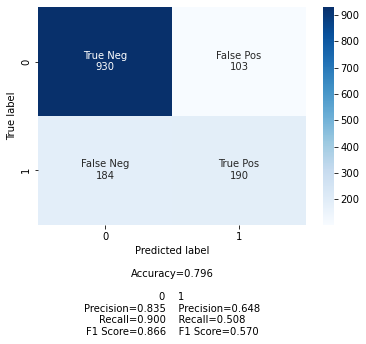

In [22]:
cf_matrix_forest = confusion_matrix(y_test, predict_forest)
make_confusion_matrix(cf_matrix_forest, group_names)

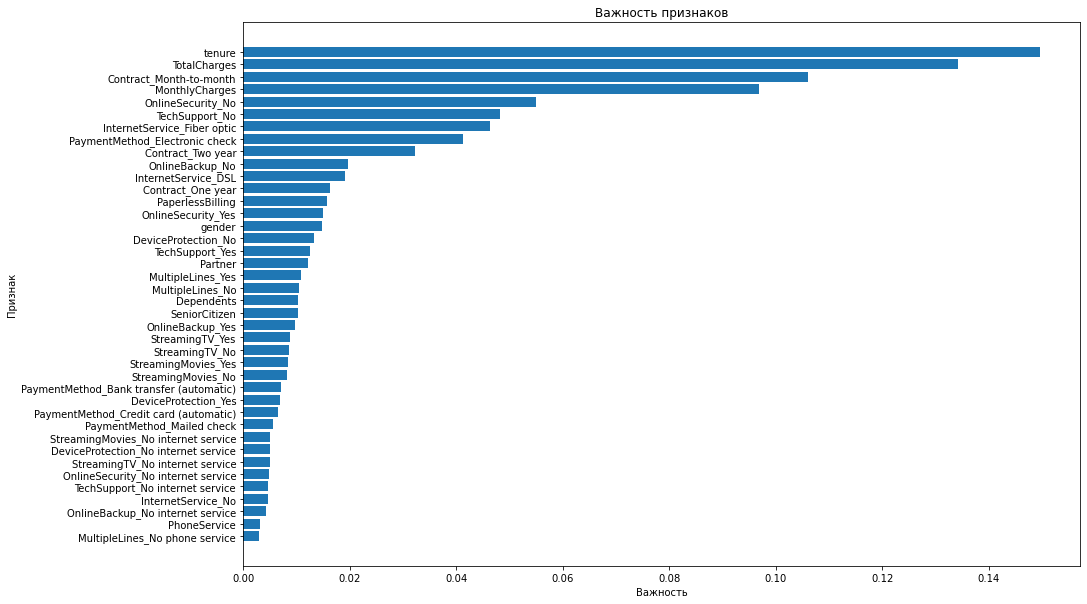

In [23]:
# Создаем датафрейм на основе важности признаков
importance = pd.DataFrame({'features': X.columns, 'feature_importances_':forest.feature_importances_,})
# Сортируем по возрастанию
importance = importance.sort_values(by='feature_importances_')

# Количество признаков
n_features = X_train.shape[1]

# Визуализируем график важности признаков
plt.figure(figsize=(15, 10))
plt.barh(np.arange(n_features), importance.feature_importances_)
plt.yticks(np.arange(n_features), importance.features)
plt.ylabel("Признак")
plt.xlabel('Важность')
plt.title('Важность признаков')
plt.show()

# KNN

In [24]:
# Ошибка предказания
error_rate=list()
# Вычисляем оптимальное число соседей
for i in range(1, 40):
    # Создаем экземпляр класса
    knn=KNeighborsClassifier(n_neighbors=i)
    # Обучаем модель на тренировочных данных
    knn.fit(X_train,y_train)
    # Предсказание на тестовых данных
    prediction_i=knn.predict(X_test)
    error_rate.append(np.sum(prediction_i != y_test))

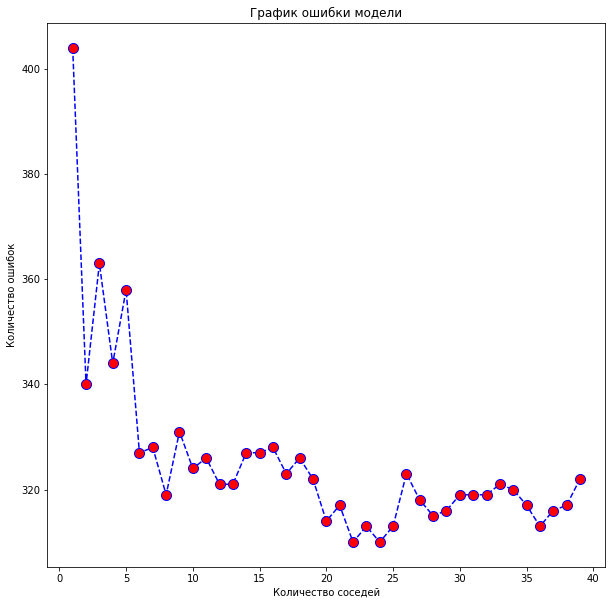

In [25]:
plt.figure(figsize=(10, 10))
plt.plot(range(1, 40), error_rate, color="blue", linestyle="--", marker="o", markerfacecolor="red", markersize=10)
plt.title("График ошибки модели")
plt.xlabel("Количество соседей")
plt.ylabel("Количество ошибок");

In [26]:
# Обучаем модель на n_neighbors=23
knn=KNeighborsClassifier(n_neighbors=23)
# Обучаем модель
knn.fit(X_train, y_train)
# Предсказание модели
predict_knn=knn.predict(X_test)

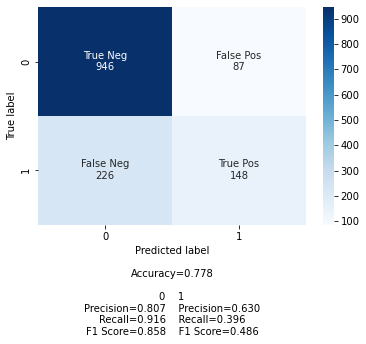

In [27]:
# Матрица ошибок
cf_knn = confusion_matrix(y_test, predict_knn)
make_confusion_matrix(cf_knn, group_names)

# Дерево решений

In [28]:
# Сетка параметров
param_tree = {'max_depth': list(np.arange(1, 15, 1)), 
              'criterion': ['gini', 'entropy']}
# Cоздаем экземпляр класса GridSearchCV       
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_tree, n_jobs =-1, cv=5)
# Обучаем модель
grid_tree.fit(X_train, y_train)
# предсказание модели
predict_tree = grid_tree.predict(X_test)
print(f'Оптимальные гиперпараметры модели - {grid_tree.best_params_}')

Оптимальные гиперпараметры модели - {'criterion': 'gini', 'max_depth': 5}


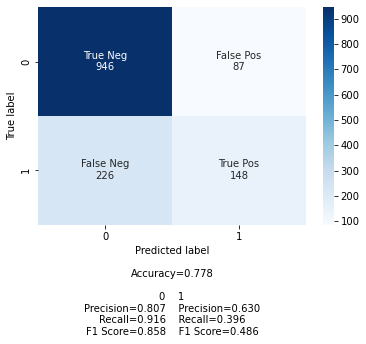

In [29]:
# Матрица ошибок
cf_tree = confusion_matrix(y_test, predict_knn)
make_confusion_matrix(cf_tree, group_names)

# Метод опорных векторов

In [30]:
# Сетка параметров
param_grid = {"C":[1, 5, 10],
            "gamma":[1, 0.01, 0.001]} 

grid_svc = GridSearchCV(SVC(), param_grid, cv=5)
grid_svc.fit(X_train,y_train)
print(f'Оптимальные гиперпараметры модели = {grid_svc.best_params_}')

Оптимальные гиперпараметры модели = {'C': 1, 'gamma': 0.001}


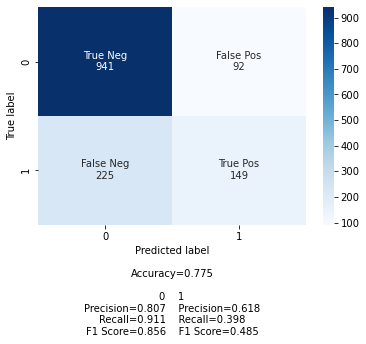

In [31]:
predict_svc = grid_svc.predict(X_test)
cf_svc = confusion_matrix(y_test, predict_svc)
make_confusion_matrix(cf_svc, group_names)

# Логистическая регрессия

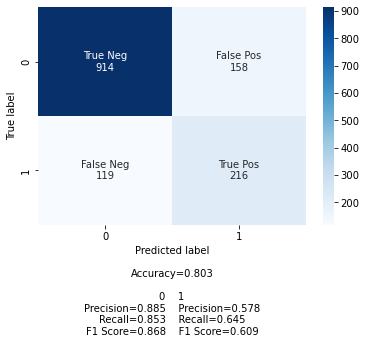

In [32]:
Lr = LogisticRegression(max_iter=133)
Lr.fit(X_train, y_train)
predict = Lr.predict(X_test)
cf_lr = confusion_matrix(predict, y_test)
make_confusion_matrix(cf_lr, group_names)

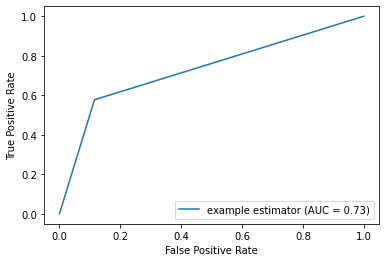

In [33]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='example estimator')
display.plot()
plt.show()